# The data block API

In [ ]:
from fastai.gen_doc.nbdoc import *
from fastai.vision import * 
from fastai import *
np.random.seed(42)

The data block API lets you customize how to create a [`DataBunch`](/basic_data.html#DataBunch) by isolating the underlying parts of that process in separate blocks, mainly:
- where are the inputs
- how to split the data into a training and validation set
- how to label them
- possible transforms to apply
- how to warp in dataloaders and create the [`DataBunch`](/basic_data.html#DataBunch)

This is a bit longer than using the factory methods but is way more flexible. As usual, we'll begin with end-to-end examples, then switch to the details of each of those parts.

## Examples of use

Let's begin by our traditional MNIST example.

In [ ]:
path = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/test'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/valid'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/history.csv'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/models')]

In [ ]:
(path/'train').ls()

[PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/7'),
 PosixPath('/home/ubuntu/.fastai/data/mnist_tiny/train/3')]

In [`vision.data`](/vision.data.html#vision.data), we create an easy [`DataBunch`](/basic_data.html#DataBunch) suitable for classification by simply typing:

In [ ]:
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=24)

This is aimed at data that is in folders following an ImageNet style, with a train and valid directory containing each one subdirectory per class, where all the pictures are. With the data block API, the same thing is achieved like this:

In [ ]:
data = (ImageItemList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_folder()              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(tfms, size=64)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

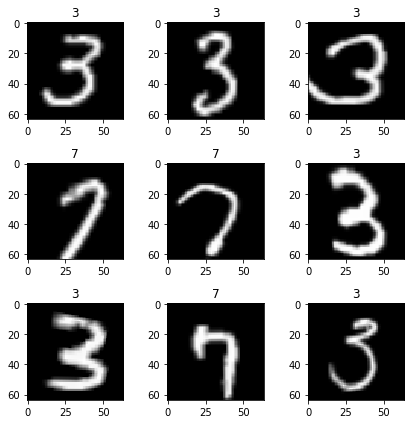

In [ ]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [ ]:
data.train_ds[0], data.test_ds.classes

((Image (3, 64, 64), Category 7), ['7', '3'])

Let's look at another example from [`vision.data`](/vision.data.html#vision.data) with the planet dataset. This time, it's a multiclassification problem with the labels in a csv file and no given split between valid and train data, so we use a random split. The factory method is:

In [ ]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
data = ImageDataBunch.from_csv(planet, folder='train', size=128, suffix='.jpg', sep = ' ', ds_tfms=planet_tfms)

With the data block API we can rewrite this like that:

In [ ]:
data = (ImageItemList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        #Where to find the data? -> in planet 'train' folder
        .random_split_by_pct()
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_df(sep=' ')
        #How to label? -> use the csv file
        .transform(planet_tfms, size=128)
        #Data augmentation? -> use tfms with a size of 128
        .databunch())                          
        #Finally -> use the defaults for conversion to databunch

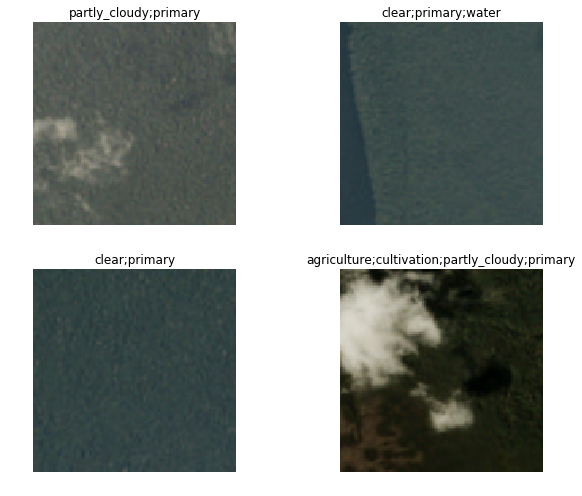

In [ ]:
data.show_batch(rows=2, figsize=(9,7))

The data block API also allows you to use dataset types for which there is no direct [`ImageDataBunch`](/vision.data.html#ImageDataBunch) factory method. For a segmentation task, for instance, we can use it to quickly get a [`DataBunch`](/basic_data.html#DataBunch). Let's take the example of the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/). The images are in an 'images' folder and their corresponding mask is in a 'labels' folder.

In [ ]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We have a file that gives us the names of the classes (what each code inside the masks corresponds to: a pedestrian, a tree, a road...)

In [ ]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

And we define the following function that infers the mask filename from the image filename.

In [ ]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

Then we can easily define a [`DataBunch`](/basic_data.html#DataBunch) using the data block API. Here we need to use `tfm_y=True` in the transform call because we need the same transforms to be applied to the target mask as were applied to the image.

In [ ]:
data = (SegmentationItemList.from_folder(path_img)
        .random_split_by_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True)
        .databunch())

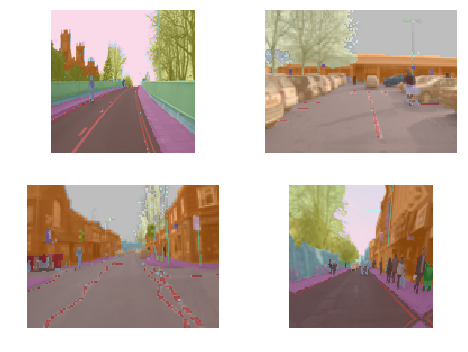

In [ ]:
data.show_batch(rows=2, figsize=(7,5))

One last example for object detection. We use our tiny sample of the [COCO dataset](http://cocodataset.org/#home) here. There is a helper function in the library that reads the annotation file and returns the list of images names with the list of labelled bboxes associated to it. We convert it to a dictionary that maps image names with their bboxes and then write the function that will give us the target for each image filename.

In [ ]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

The following code is very similar to what we saw before. The only new addition is the use of special function to collate the samples in batches. This comes from the fact that our images may have multiple bounding boxes, so we need to pad them to the largest number of bounding boxes.

In [ ]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco
        .random_split_by_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms with tfm_y=True
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch and we use bb_pad_collate

TypeError: unhashable type: 'numpy.ndarray'

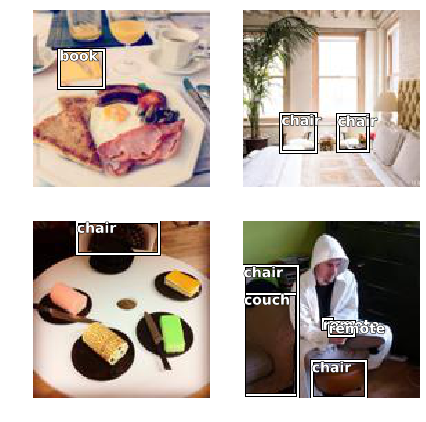

In [ ]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))

## Provide inputs

The inputs we want to feed our model are regrouped in the following class. The class contains methods to get the corresponding labels.

In [ ]:
show_doc(ItemList, title_level=3, doc_string=False)

<h3 id="ItemList"><code>class</code> <code>ItemList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L38" class="source_link">[source]</a></h3>

> <code>ItemList</code>(`items`:`Iterator`, `create_func`:`Callable`=`None`, `path`:`PathOrStr`=`'.'`, `label_cls`:`Callable`=`None`, `xtra`:`Any`=`None`, `processor`:[`PreProcessor`](/data_block.html#PreProcessor)=`None`)

This class regroups the inputs for our model in `items` and saves a `path` attribute which is where it will look for any files (image files, csv file with labels...) `create_func` is applied to `items` to get the final output. `label_cls` will be called to create the labels from the result of the label function, `xtra` contains additional information (usually an underlying dataframe) and `processor` is to be applied to the inputs after the splitting and labelling.

In [ ]:
show_doc(ItemList.from_folder)

<h4 id="ItemList.from_folder"><code>from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L81" class="source_link">[source]</a></h4>

> <code>from_folder</code>(`path`:`PathOrStr`, `extensions`:`StrList`=`None`, `recurse`=`True`, `kwargs`) → `ItemList`

Get the list of files in `path` that have a suffix in `extensions`. `recurse` determines if we search subfolders.  

In [ ]:
show_doc(ItemList.from_df)

<h4 id="ItemList.from_df"><code>from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L86" class="source_link">[source]</a></h4>

> <code>from_df</code>(`df`:`DataFrame`, `path`:`PathOrStr`=`'.'`, `col`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `kwargs`) → `ItemList`

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the inputs in the `col` of `df`.  

In [ ]:
show_doc(ItemList.from_csv)

<h4 id="ItemList.from_csv"><code>from_csv</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L93" class="source_link">[source]</a></h4>

> <code>from_csv</code>(`path`:`PathOrStr`, `csv_name`:`str`, `col`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`0`, `header`:`str`=`'infer'`, `kwargs`) → `ItemList`

Create an [`ItemList`](/data_block.html#ItemList) in `path` from the inputs in the `col` of `path/csv_name` opened with `header`.  

## Split the data

The following functions are methods of `ItemList`, to create an `ItemLists` in different ways.

In [ ]:
show_doc(ItemList.random_split_by_pct)

<h4 id="ItemList.random_split_by_pct"><code>random_split_by_pct</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L138" class="source_link">[source]</a></h4>

> <code>random_split_by_pct</code>(`valid_pct`:`float`=`0.2`, `seed`:`int`=`None`) → `ItemLists`

Split the items randomly by putting `valid_pct` in the validation set. Set the `seed` in numpy if passed.  

In [ ]:
show_doc(ItemList.split_by_files)

<h4 id="ItemList.split_by_files"><code>split_by_files</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L150" class="source_link">[source]</a></h4>

> <code>split_by_files</code>(`valid_names`:`ItemList`) → `ItemLists`

Split the data by using the names in `valid_names` for validation.  

In [ ]:
show_doc(ItemList.split_by_fname_file)

<h4 id="ItemList.split_by_fname_file"><code>split_by_fname_file</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L155" class="source_link">[source]</a></h4>

> <code>split_by_fname_file</code>(`fname`:`PathOrStr`, `path`:`PathOrStr`=`None`) → `ItemLists`

Split the data by using the file names in `fname` for the validation set. `path` will override `self.path`.  

In [ ]:
show_doc(ItemList.split_by_folder)

<h4 id="ItemList.split_by_folder"><code>split_by_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L134" class="source_link">[source]</a></h4>

> <code>split_by_folder</code>(`train`:`str`=`'train'`, `valid`:`str`=`'valid'`) → `ItemLists`

Split the data depending on the folder (`train` or `valid`) in which the filenames are.  

In [ ]:
jekyll_note("This method looks at the folder immediately after `self.path` for `valid` and `train`.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the folder immediately after `self.path` for `valid` and `train`.</div>

In [ ]:
show_doc(ItemList.split_by_idx)

<h4 id="ItemList.split_by_idx"><code>split_by_idx</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L125" class="source_link">[source]</a></h4>

> <code>split_by_idx</code>(`valid_idx`:`Collection`\[`int`\]) → `ItemLists`

Split the data according to the indexes in `valid_idx`.  

In [ ]:
show_doc(ItemList.split_by_valid_func)

<h4 id="ItemList.split_by_valid_func"><code>split_by_valid_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L145" class="source_link">[source]</a></h4>

> <code>split_by_valid_func</code>(`func`:`Callable`) → `ItemLists`

Split the data by result of `func` (which returns `True` for validation set)  

In [ ]:
show_doc(ItemList.split_from_df)

<h4 id="ItemList.split_from_df"><code>split_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L161" class="source_link">[source]</a></h4>

> <code>split_from_df</code>(`col`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`2`)

Split the data from the `col` in the dataframe in `self.xtra`.  

## Labelling the inputs

All the followings are methods of `ItemList` (`ItemLists` delegates them to each one of its `ItemList`). Note that some of them are primarly intended for inputs that are filenames and might not work in general situations.

In [ ]:
show_doc(ItemList.label_from_list)

<h4 id="ItemList.label_from_list"><code>label_from_list</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L174" class="source_link">[source]</a></h4>

> <code>label_from_list</code>(`labels`:`Iterator`, `label_cls`:`Callable`=`None`, `template`:`Callable`=`None`, `kwargs`) → `LabelList`

Label `self.items` with `labels` using `label_cls` and optionally `template`.  

In [ ]:
show_doc(ItemList.label_from_df)

<h4 id="ItemList.label_from_df"><code>label_from_df</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L184" class="source_link">[source]</a></h4>

> <code>label_from_df</code>(`cols`:`Union`\[`int`, `Collection`\[`int`\], `str`, `StrList`\]=`1`, `sep`=`None`, `kwargs`)

Label `self.items` from the values in `cols` in `self.xtra`. If `sep` is passed, will split the labels accordingly.  

In [ ]:
show_doc(ItemList.label_const)

<h4 id="ItemList.label_const"><code>label_const</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L190" class="source_link">[source]</a></h4>

> <code>label_const</code>(`const`:`Any`=`0`, `kwargs`) → `LabelList`

Label every item with `const`.  

In [ ]:
show_doc(ItemList.label_from_folder)

<h4 id="ItemList.label_from_folder"><code>label_from_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L198" class="source_link">[source]</a></h4>

> <code>label_from_folder</code>(`kwargs`) → `LabelList`

Give a label to each filename depending on its folder.  

In [ ]:
jekyll_note("This method looks at the last subfolder in the path to determine the classes.")

<div markdown="span" class="alert alert-info" role="alert"><i class="fa fa-info-circle"></i> <b>Note: </b>This method looks at the last subfolder in the path to determine the classes.</div>

In [ ]:
show_doc(ItemList.label_from_func)

<h4 id="ItemList.label_from_func"><code>label_from_func</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L194" class="source_link">[source]</a></h4>

> <code>label_from_func</code>(`func`:`Callable`, `kwargs`) → `LabelList`

Apply `func` to every input to get its label.  

This method is primarly intended for inputs that are filenames, but could work in other settings.

In [ ]:
show_doc(ItemList.label_from_re)

<h4 id="ItemList.label_from_re"><code>label_from_re</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L202" class="source_link">[source]</a></h4>

> <code>label_from_re</code>(`pat`:`str`, `full_path`:`bool`=`False`, `kwargs`) → `LabelList`

Apply the re in `pat` to determine the label of every filename.  If `full_path`, search in the full name.  

In [ ]:
show_doc(LabelList, title_level=3, doc_string=False)

<h3 id="LabelList"><code>class</code> <code>LabelList</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L323" class="source_link">[source]</a></h3>

> <code>LabelList</code>(`x`:[`ItemList`](/data_block.html#ItemList), `y`:[`ItemList`](/data_block.html#ItemList), `tfms`:`Union`\[`Callable`, `Collection`\[`Callable`\]\]=`None`, `tfm_y`:`bool`=`False`, `kwargs`) :: [`Dataset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)

The basic dataset in fastai. Inputs are in `x`, targets in `y`. Optionally apply `tfms` to `x` and also `y` if `tfm_y` is `True`. 

In [ ]:
show_doc(LabelList.process)

<h4 id="LabelList.process"><code>process</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L361" class="source_link">[source]</a></h4>

> <code>process</code>(`xp`=`None`, `yp`=`None`)

Launch the preprocessing on `xp` and `yp`.  

In [ ]:
show_doc(LabelList.transform)

<h4 id="LabelList.transform"><code>transform</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L373" class="source_link">[source]</a></h4>

> <code>transform</code>(`tfms`:`Union`\[`Callable`, `Collection`\[`Callable`\]\], `tfm_y`:`bool`=`None`, `kwargs`)

Set the `tfms` and `` tfm_y` value to be applied to the inputs and targets.  

In [ ]:
show_doc(ItemLists, doc_string=False, title_level=3)

<h3 id="ItemLists"><code>class</code> <code>ItemLists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L241" class="source_link">[source]</a></h3>

> <code>ItemLists</code>(`path`:`PathOrStr`, `train`:[`ItemList`](/data_block.html#ItemList), `valid`:[`ItemList`](/data_block.html#ItemList), `test`:[`ItemList`](/data_block.html#ItemList)=`None`)

Data in `path` split between several streams of inputs, `train`, `valid` and maybe `test`.

In [ ]:
show_doc(LabelLists, title_level=3, doc_string=False)

<h3 id="LabelLists"><code>class</code> <code>LabelLists</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L293" class="source_link">[source]</a></h3>

> <code>LabelLists</code>(`path`:`PathOrStr`, `train`:[`ItemList`](/data_block.html#ItemList), `valid`:[`ItemList`](/data_block.html#ItemList), `test`:[`ItemList`](/data_block.html#ItemList)=`None`) :: [`ItemLists`](/data_block.html#ItemLists)

Data in `path` split between several streams of inputs/targets, `train`, `valid` and maybe `test`.

In [ ]:
show_doc(LabelLists.add_test)

<h4 id="LabelLists.add_test"><code>add_test</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L309" class="source_link">[source]</a></h4>

> <code>add_test</code>(`items`:`Iterator`, `label`:`Any`=`None`)

Add test set containing items from `items` and an arbitrary `label`  

In [ ]:
show_doc(LabelLists.add_test_folder)

<h4 id="LabelLists.add_test_folder"><code>add_test_folder</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L318" class="source_link">[source]</a></h4>

> <code>add_test_folder</code>(`test_folder`:`str`=`'test'`, `label`:`Any`=`None`)

Add test set containing items from folder `test_folder` and an arbitrary `label`.  

In [ ]:
show_doc(LabelLists.databunch)

<h4 id="LabelLists.databunch"><code>databunch</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L304" class="source_link">[source]</a></h4>

> <code>databunch</code>(`path`:`PathOrStr`=`None`, `kwargs`) → `ImageDataBunch`

Create an [`DataBunch`](/basic_data.html#DataBunch) from self, `path` will override `self.path`, `kwargs` are passed to [`DataBunch.create`](/basic_data.html#DataBunch.create).  

## Preprocessing

Preprocessing is a step that happens after the data has been split and labelled, where the inputs and targets go through a bunch of `PreProcessor`.

In [ ]:
show_doc(PreProcessor, title_level=3, doc_string=False)

<h3 id="PreProcessor"><code>class</code> <code>PreProcessor</code><a href="https://github.com/fastai/fastai/blob/master/fastai/data_block.py#L34" class="source_link">[source]</a></h3>

> <code>PreProcessor</code>()

Basic class that will regroup functions applied to the train set and recording an inner state (vocabulary, statistics of transforms) that it will keep when applied to the validation and maybe the test set.

## Undocumented Methods - Methods moved below this line will intentionally be hidden

## New Methods - Please document or move to the undocumented section